In [1]:
def print_mask_counts(json_data):
    for frame, masks in json_data.items():
        num_masks = len(masks)
        print(f"Frame {frame}: {num_masks} masks")

# Example usage
#print_mask_counts(filtered_masks_reel)

In [2]:
import json

# Read the JSON files
with open('reel_fods_segmentation/barycentres_general.json', 'r') as file:
    filtered_masks_reel = json.load(file)

with open('synthetisated_fods_segmented/barycentres_general.json', 'r') as file:
    filtered_masks_synthese = json.load(file)

# Apply the print_mask_counts function
print_mask_counts(filtered_masks_reel)
print_mask_counts(filtered_masks_synthese)

Frame 00000: 43 masks
Frame 00001: 58 masks
Frame 00002: 65 masks
Frame 00003: 62 masks
Frame 00004: 39 masks
Frame 00005: 49 masks
Frame 00006: 53 masks
Frame 00007: 63 masks
Frame 00008: 54 masks
Frame 00009: 53 masks
Frame 00010: 51 masks
Frame 00011: 51 masks
Frame 00012: 45 masks
Frame 00013: 49 masks
Frame 00014: 59 masks
Frame 00015: 54 masks
Frame 00016: 51 masks
Frame 00017: 50 masks
Frame 00018: 59 masks
Frame 00019: 52 masks
Frame 00020: 47 masks
Frame 00021: 52 masks
Frame 00022: 61 masks
Frame 00023: 55 masks
Frame 00024: 49 masks
Frame 00025: 35 masks
Frame 00026: 33 masks
Frame 00027: 38 masks
Frame 00028: 38 masks
Frame 00029: 43 masks
Frame 00030: 42 masks
Frame 00031: 54 masks
Frame 00032: 37 masks
Frame 00033: 47 masks
Frame 00034: 52 masks
Frame 00035: 50 masks
Frame 00036: 43 masks
Frame 00037: 49 masks
Frame 00038: 52 masks
Frame 00039: 56 masks
Frame 00040: 48 masks
Frame 00041: 51 masks
Frame 00042: 58 masks
Frame 00043: 58 masks
Frame 00044: 47 masks
Frame 0000

In [ ]:
import cv2
import json
import numpy as np

def is_white_area_above_threshold(image_path, threshold):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Calculate the white area
    white_area = np.sum(image == 255)
    
    # Calculate the total area
    total_area = image.size
    
    # Calculate the percentage of white area
    white_area_percentage = (white_area / total_area) * 100
    
    # Return True if the white area percentage is above the threshold, else False
    return white_area_percentage > threshold


In [ ]:
import os

def filter_masks(input_folder, threshold=1):
    # Load the data from the JSON file in the input folder
    data_file_path = os.path.join(input_folder, 'barycentres_general.json')
    with open(data_file_path, 'r') as file:
        data = json.load(file)

    filtered_data = {}

    for frame, masks in data.items():
        filtered_data[frame] = {}
        for mask_file, barycentre in masks.items():
            mask_path = os.path.join(input_folder, frame, mask_file)
            if is_white_area_above_threshold(mask_path, threshold):
                filtered_data[frame][mask_file] = barycentre

    return filtered_data

# Example usage
input_folder = 'fods_segmentation_sam_optim'
filtered_masks_reel = filter_masks(input_folder)

In [ ]:
input_folder = 'synthetisated_fods_segmentation_sam_optim'
filtered_masks_synthese = filter_masks(input_folder)

In [ ]:
print_mask_counts(filtered_masks_reel)

In [3]:
import numpy as np
import cv2

def compute_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Computes the Intersection over Union (IoU) between two binary masks.

    Parameters:
    - mask1 (np.ndarray): First binary mask.
    - mask2 (np.ndarray): Second binary mask.

    Returns:
    - float: IoU score (between 0 and 1).
    """
    if mask1.shape != mask2.shape:
        raise ValueError("Masks must have the same dimensions.")

    # Convert masks to binary (in case they are not strictly 0 and 1)
    mask1 = (mask1 > 0).astype(np.uint8)
    mask2 = (mask2 > 0).astype(np.uint8)

    # Compute intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    if union == 0:
        return 0.0  # Avoid division by zero

    return intersection / union



In [4]:
import numpy as np
import os

def euclidean_distance(coord1, coord2):
    return np.linalg.norm(np.array(coord1) - np.array(coord2))

def match_masks(json1, json2, distance_threshold=100):
    matched_masks = {}
    
    for frame in json1.keys() & json2.keys():  # Intersection des frames présentes dans les deux JSON
        masks1 = json1[frame]
        masks2 = json2[frame]
        
        if not masks1 or not masks2:
            continue  # Ignorer si l'un des frames n'a pas de masques
        
        matched_masks[frame] = {}
        remaining_masks2 = set(masks2.keys())
        
        for mask1, coord1 in masks1.items():
            closest_masks = []
            distances = []
            for mask2 in remaining_masks2:
                distance = euclidean_distance(coord1, masks2[mask2])
                mask1_path = os.path.join('synthetisated_fods_segmented', frame, mask1)
                mask2_path = os.path.join('reel_fods_segmentation', frame, mask2)
                mask1_image = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)
                mask2_image = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)
                iou_score = compute_iou(mask1_image, mask2_image)
                if iou_score > 0.25:
                    distances.append((distance, mask2))
            
            distances.sort()
            closest_masks = [mask2 for _, mask2 in distances[:10]]
    
            if closest_masks and all(d < distance_threshold for d, _ in distances[:5]):
                matched_masks[frame][mask1] = closest_masks
                for mask2 in closest_masks:
                    remaining_masks2.remove(mask2)  # Éviter de réutiliser un même mask2

        # Remove matched masks from the original JSONs
        for mask1, mask2_list in matched_masks[frame].items():
            del json1[frame][mask1]
            for mask2 in mask2_list:
                del json2[frame][mask2]
    
    return matched_masks

# Exemple d'utilisation :
result = match_masks(filtered_masks_synthese,filtered_masks_reel)
result



{'00040': {'mask_00000.png': ['mask_00000.png'],
  'mask_00001.png': ['mask_00005.png'],
  'mask_00002.png': ['mask_00001.png'],
  'mask_00008.png': ['mask_00011.png'],
  'mask_00009.png': ['mask_00035.png'],
  'mask_00010.png': ['mask_00024.png'],
  'mask_00013.png': ['mask_00034.png'],
  'mask_00015.png': ['mask_00002.png'],
  'mask_00032.png': ['mask_00046.png'],
  'mask_00033.png': ['mask_00049.png', 'mask_00061.png'],
  'mask_00034.png': ['mask_00022.png', 'mask_00053.png'],
  'mask_00043.png': ['mask_00065.png'],
  'mask_00044.png': ['mask_00063.png'],
  'mask_00045.png': ['mask_00064.png'],
  'mask_00046.png': ['mask_00075.png'],
  'mask_00047.png': ['mask_00089.png'],
  'mask_00051.png': ['mask_00066.png'],
  'mask_00052.png': ['mask_00070.png'],
  'mask_00053.png': ['mask_00068.png'],
  'mask_00055.png': ['mask_00074.png', 'mask_00069.png'],
  'mask_00056.png': ['mask_00073.png'],
  'mask_00057.png': ['mask_00079.png'],
  'mask_00058.png': ['mask_00081.png'],
  'mask_00061.png

In [ ]:
filtered_masks_reel

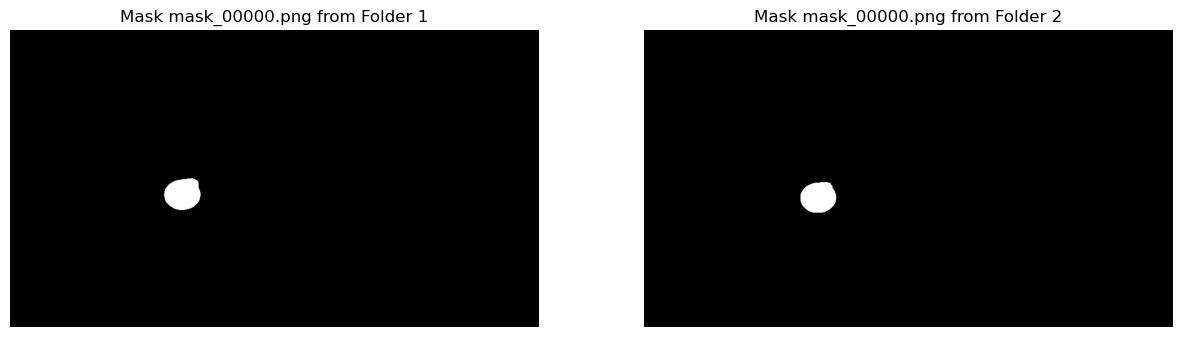

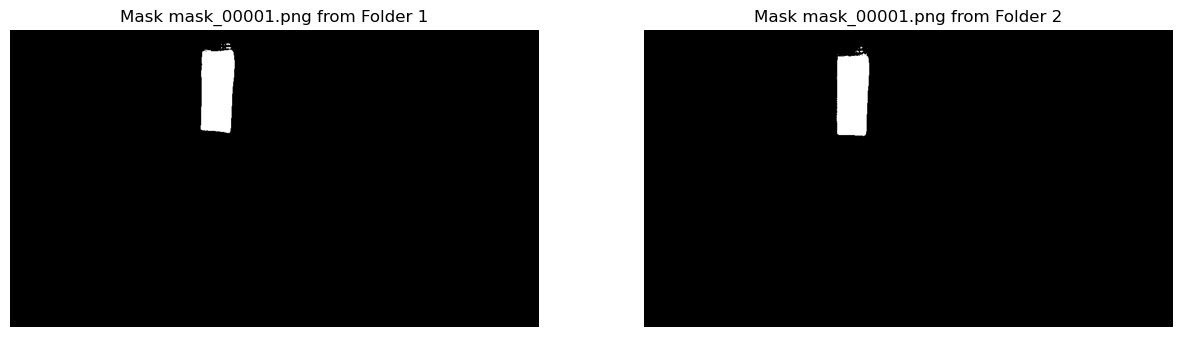

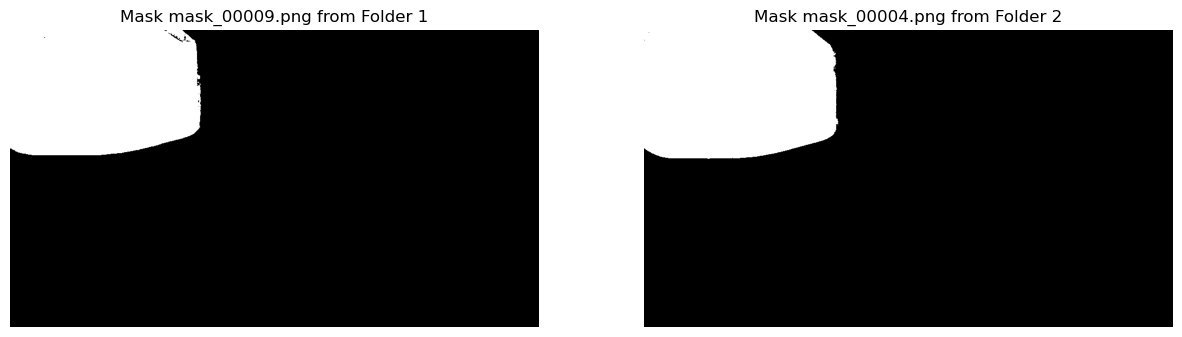

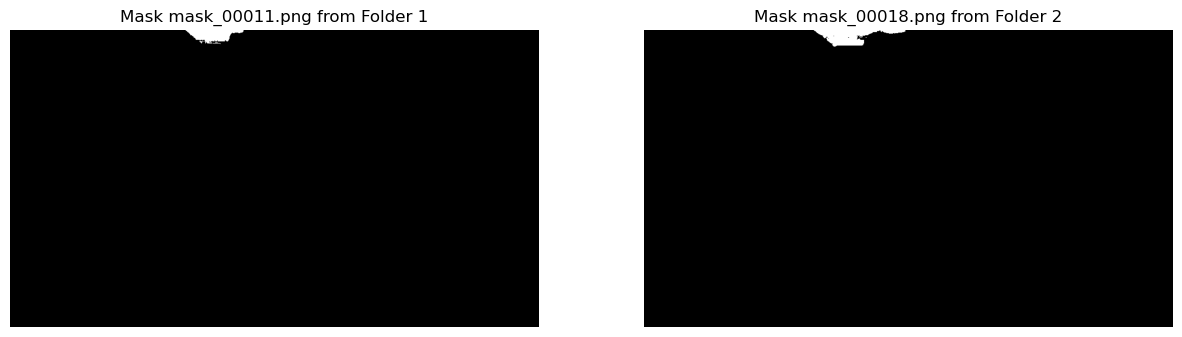

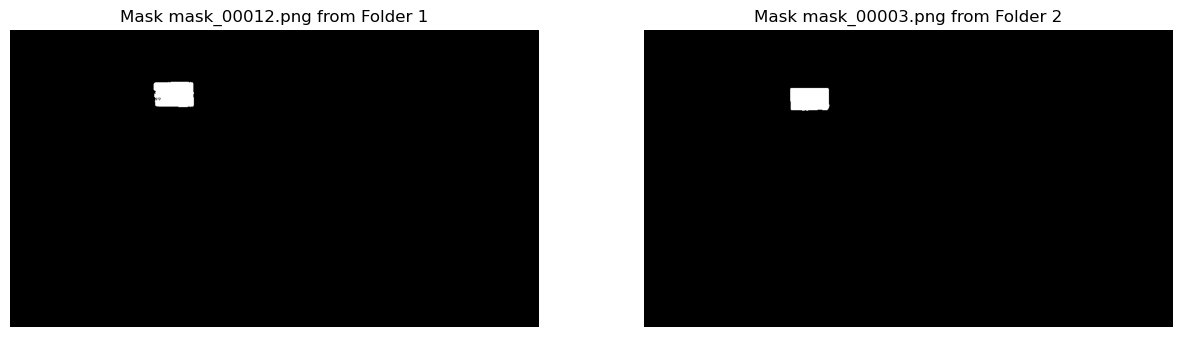

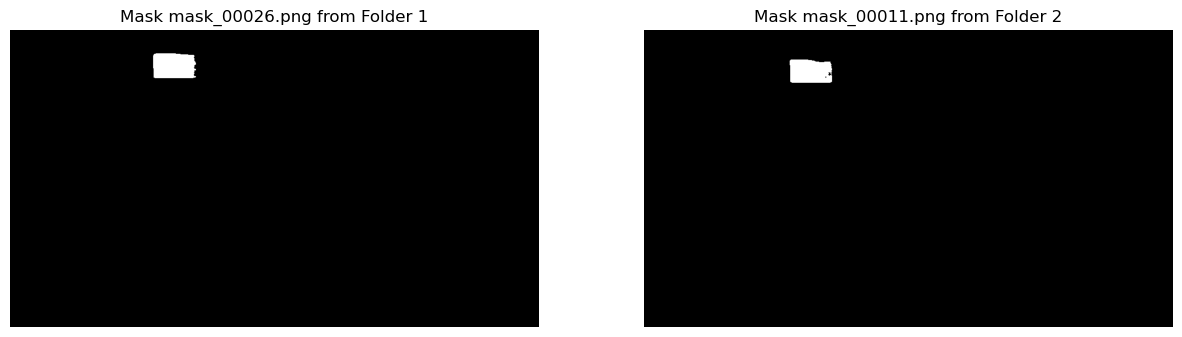

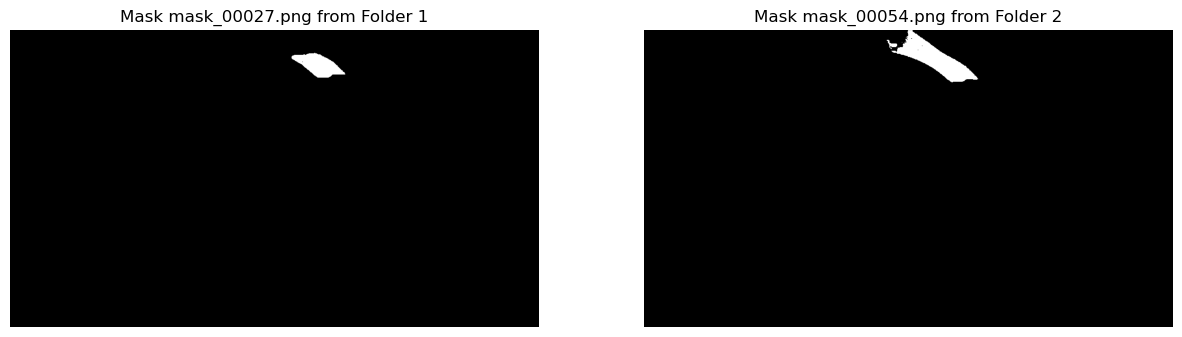

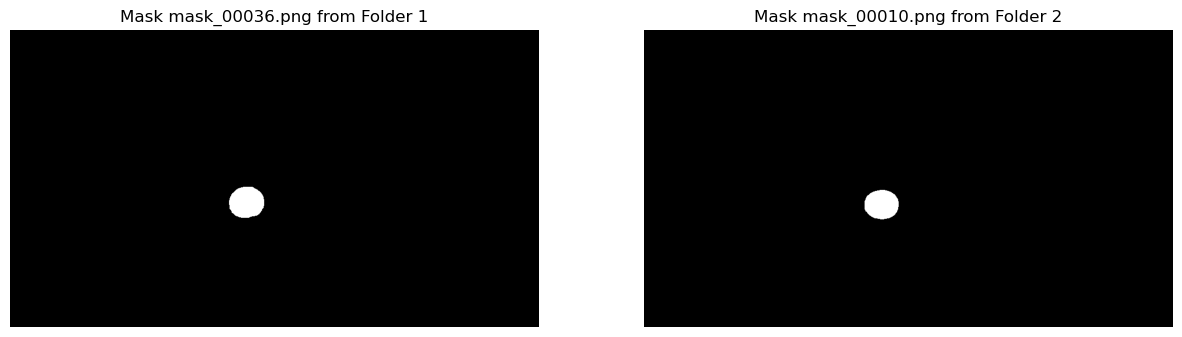

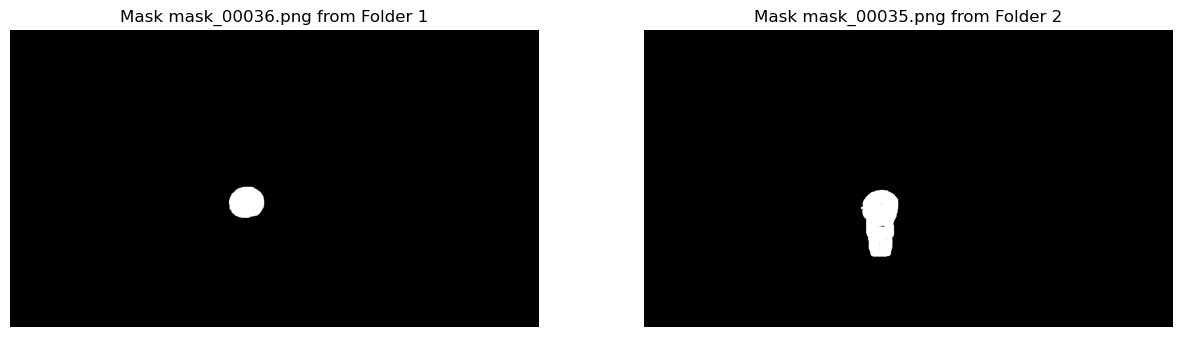

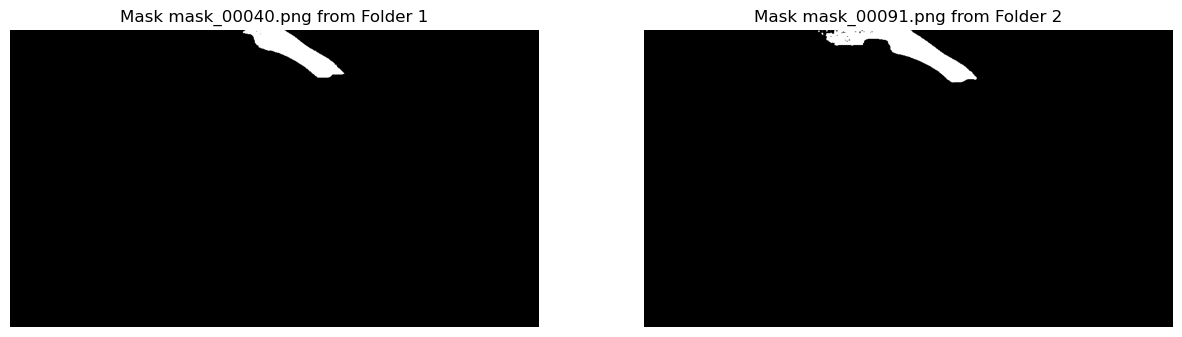

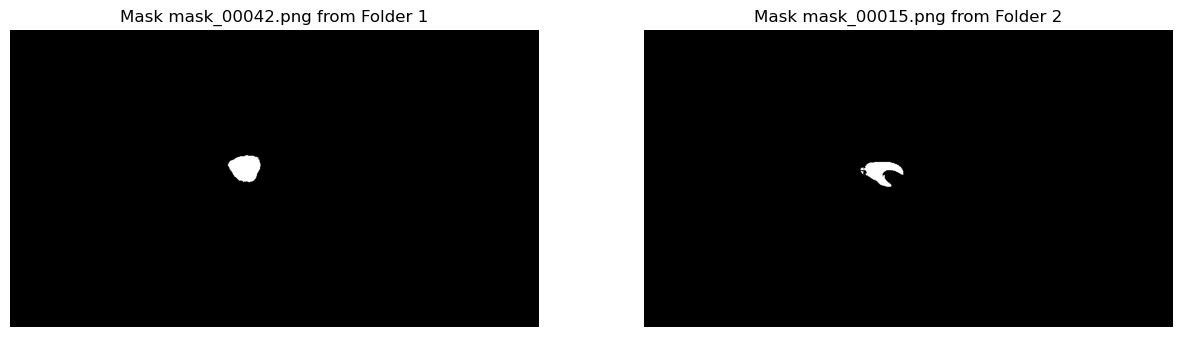

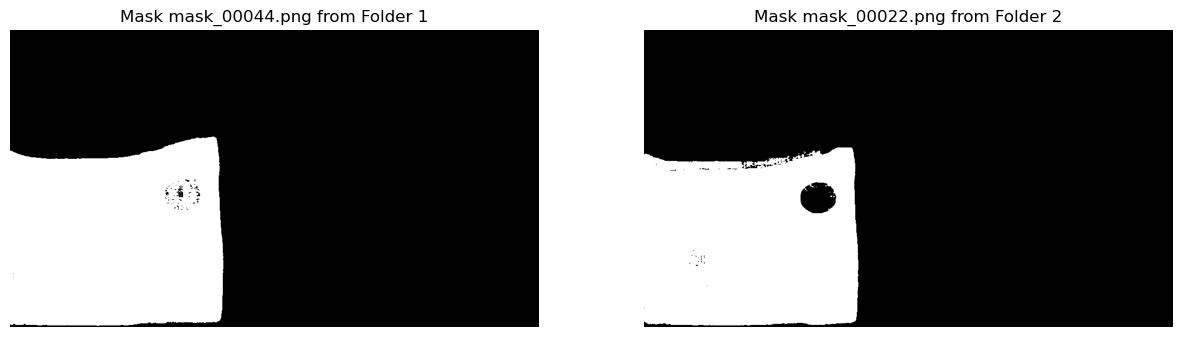

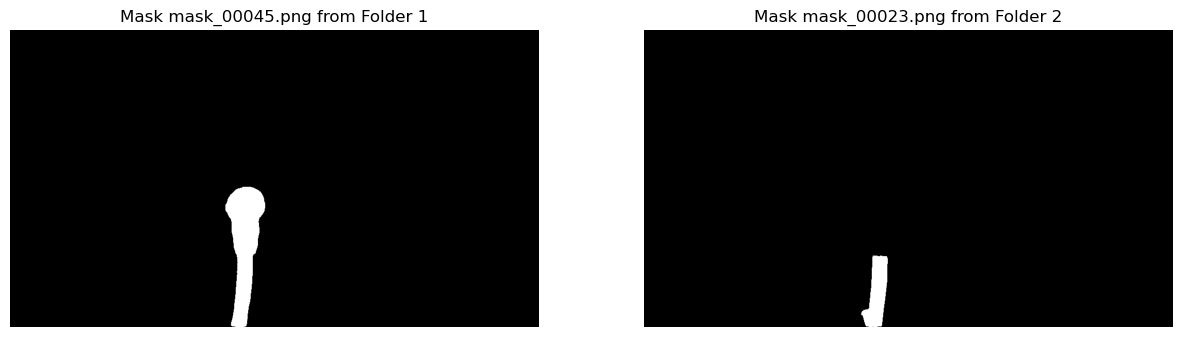

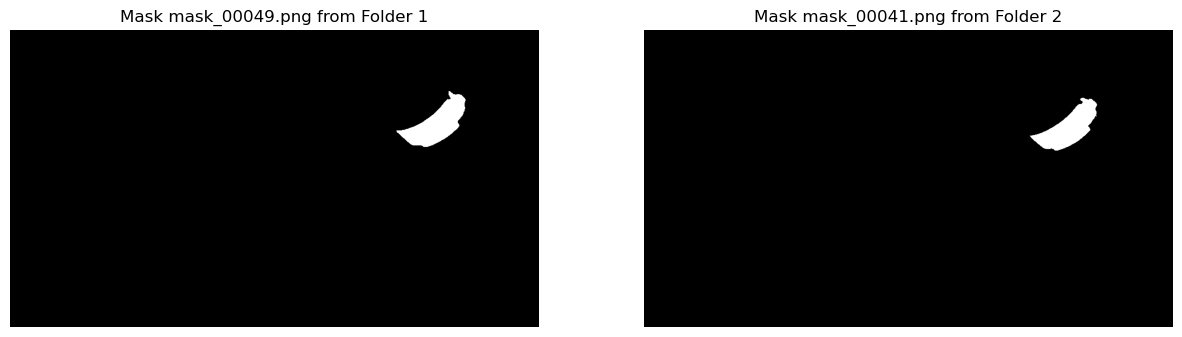

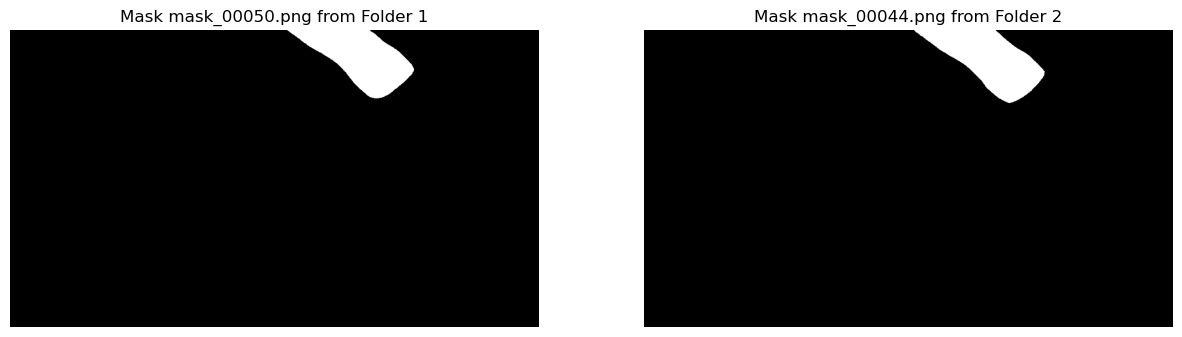

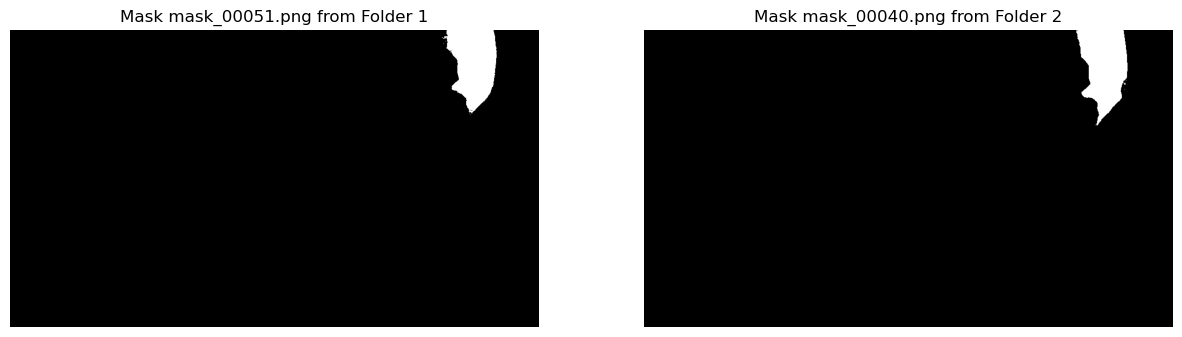

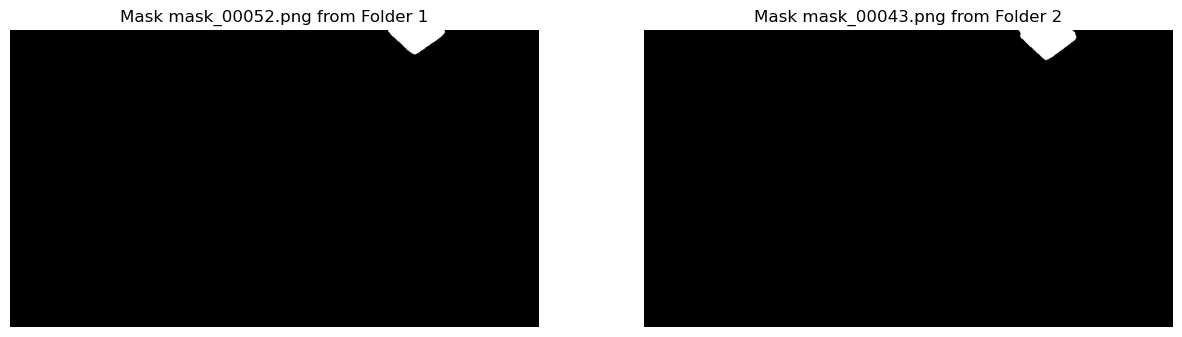

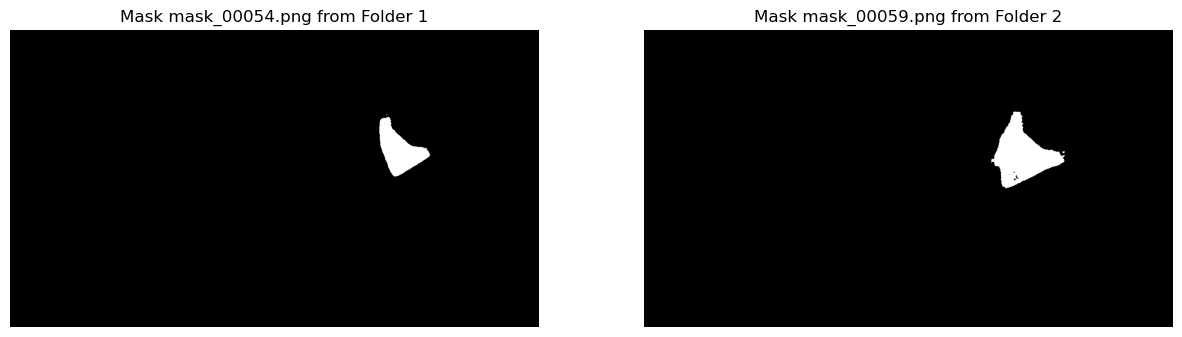

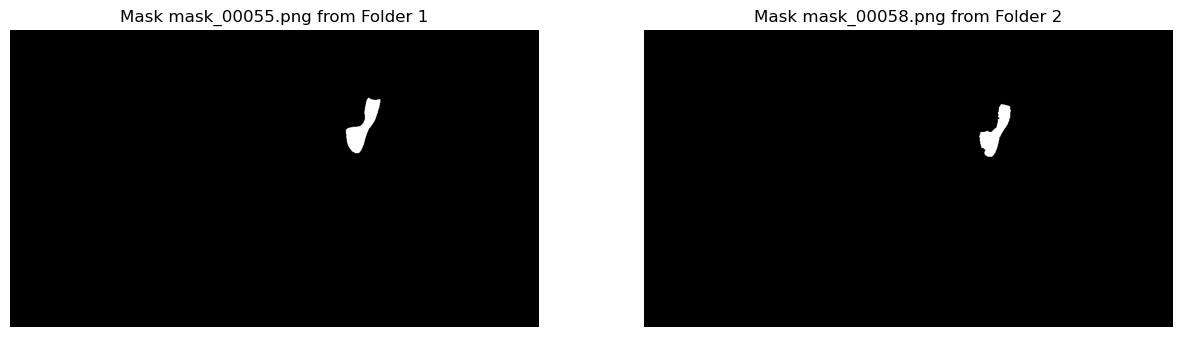

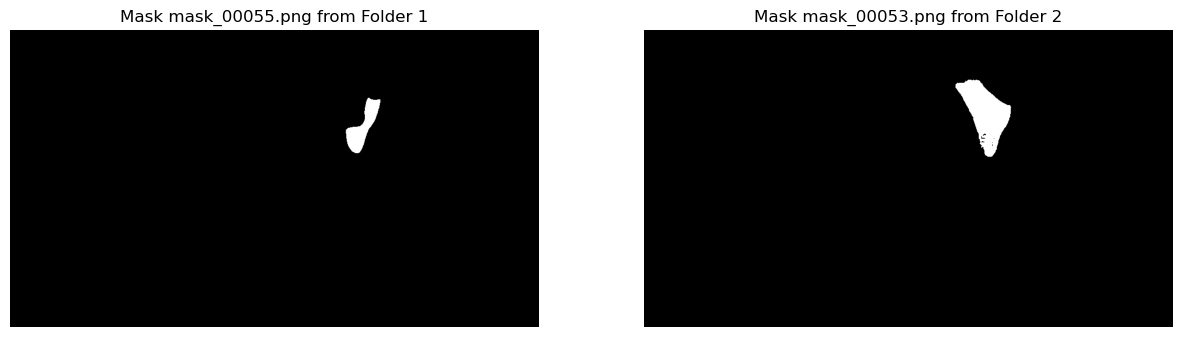

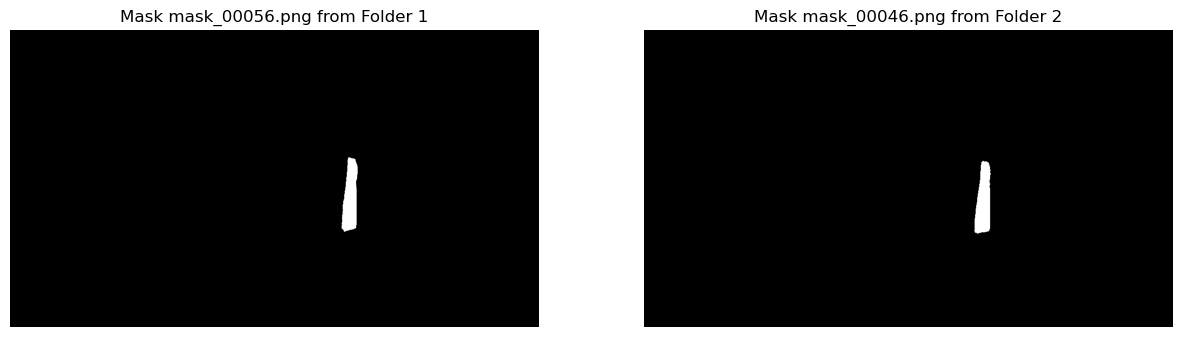

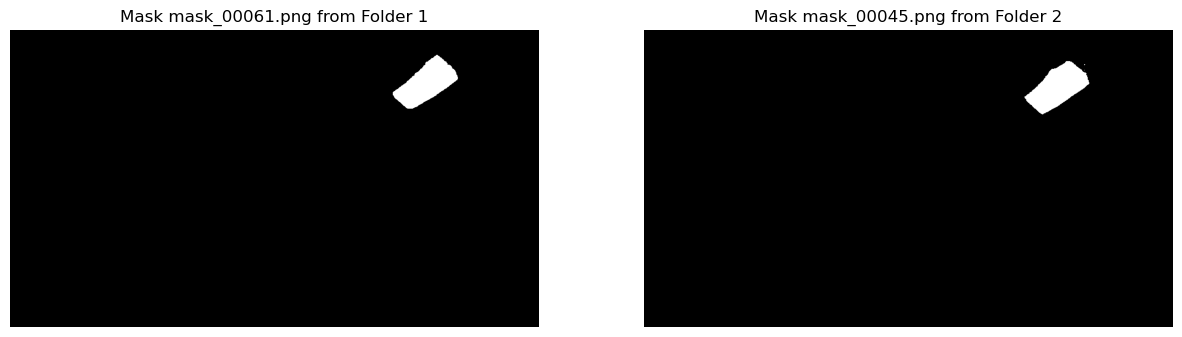

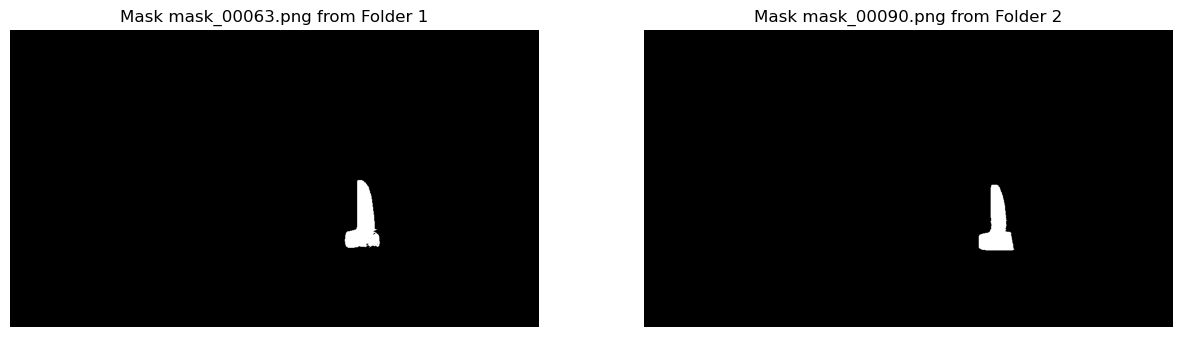

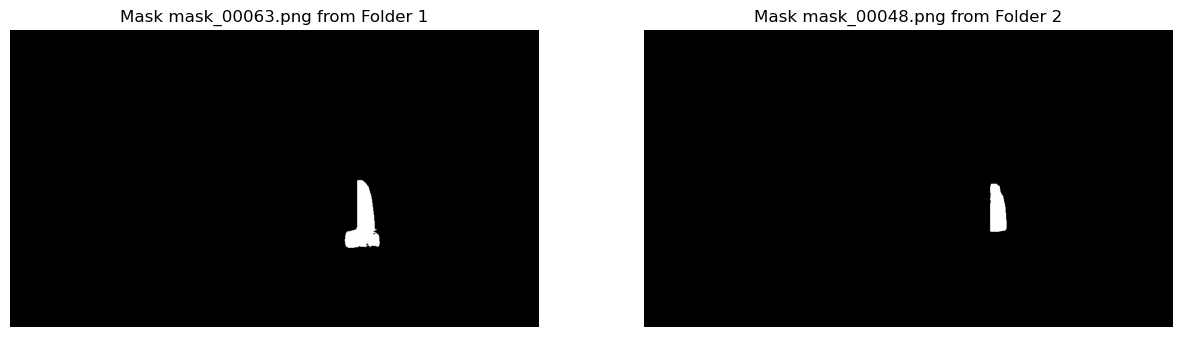

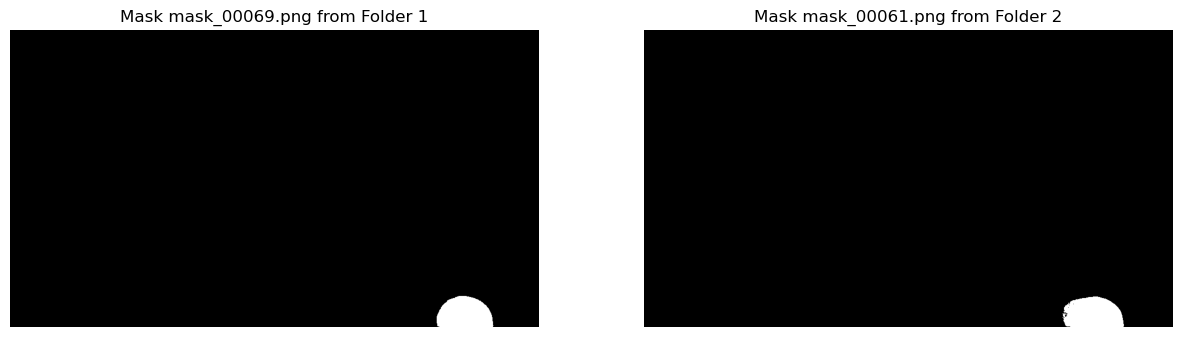

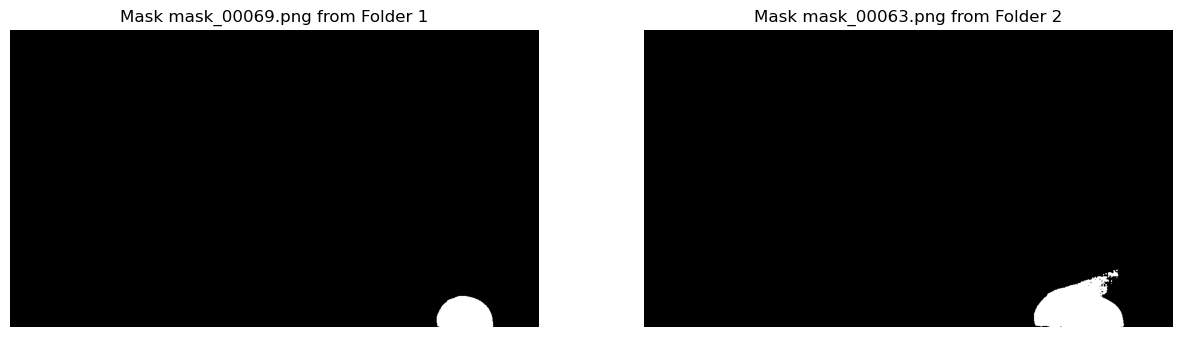

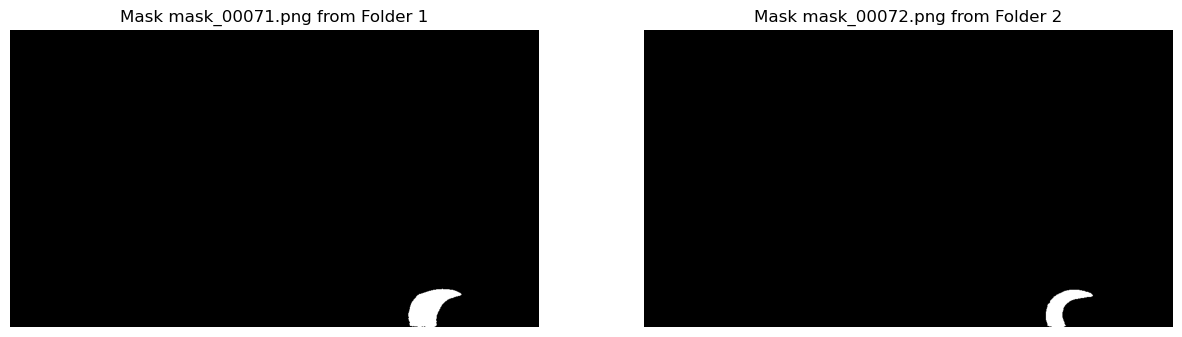

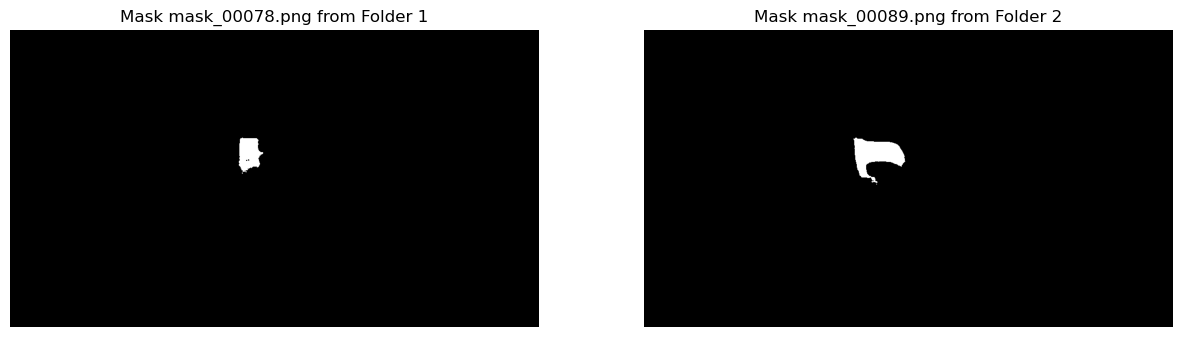

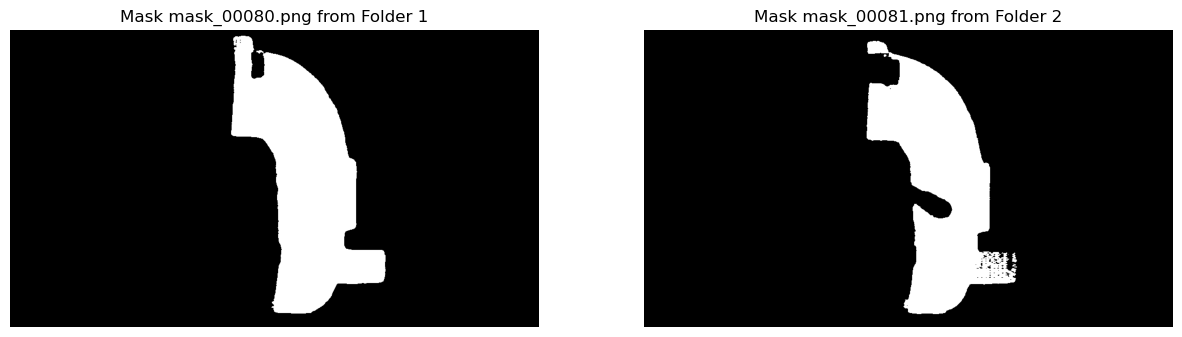

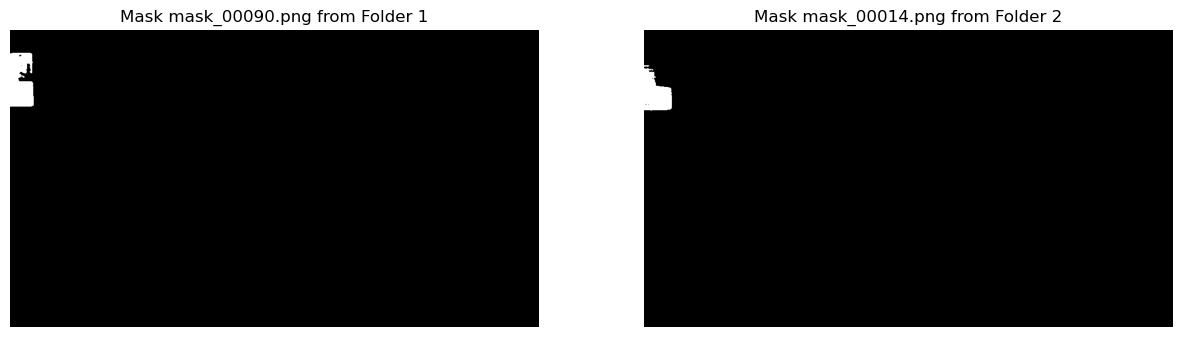

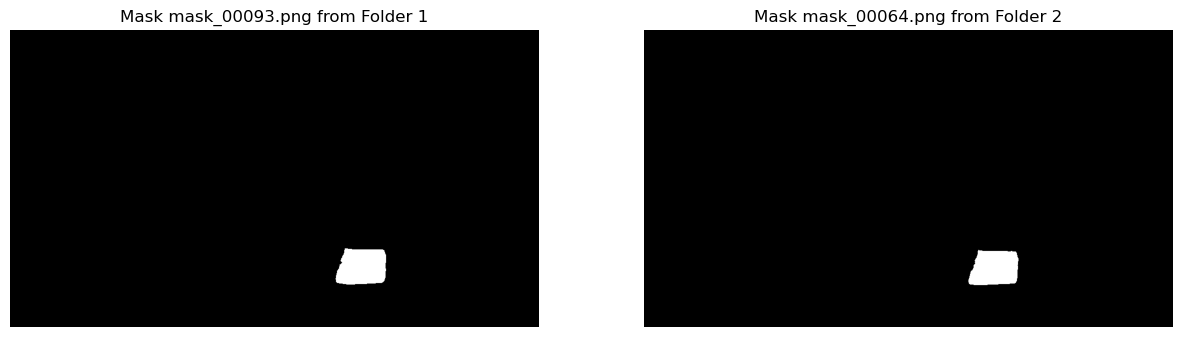

In [25]:
import os
import matplotlib.pyplot as plt

def display_mask_pairs(matched_data, frame, folder1='synthetisated_fods_segmented', folder2='reel_fods_segmentation'):
    
    if frame not in matched_data:
        print(f"No matched masks found for frame {frame}")
        return
    
    mask_pairs = matched_data[frame]
    
    for mask1, mask2 in mask_pairs.items():
        # Get the paths for the masks
        mask1_path = os.path.join(folder1, frame, mask1)
        for mask2_file in mask2:
            mask2_path = os.path.join(folder2, frame, mask2_file)
            
            # Read the images
            mask1_image = plt.imread(mask1_path)
            mask2_image = plt.imread(mask2_path)
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            axes[0].imshow(mask1_image, cmap='gray')
            axes[0].set_title(f'Mask {mask1} from Folder 1')
            axes[0].axis('off')
            
            axes[1].imshow(mask2_image, cmap='gray')
            axes[1].set_title(f'Mask {mask2_file} from Folder 2')
            axes[1].axis('off')
            
            plt.show()
        
        plt.show()

# Example usage
frame = '00044'
display_mask_pairs(result, frame)

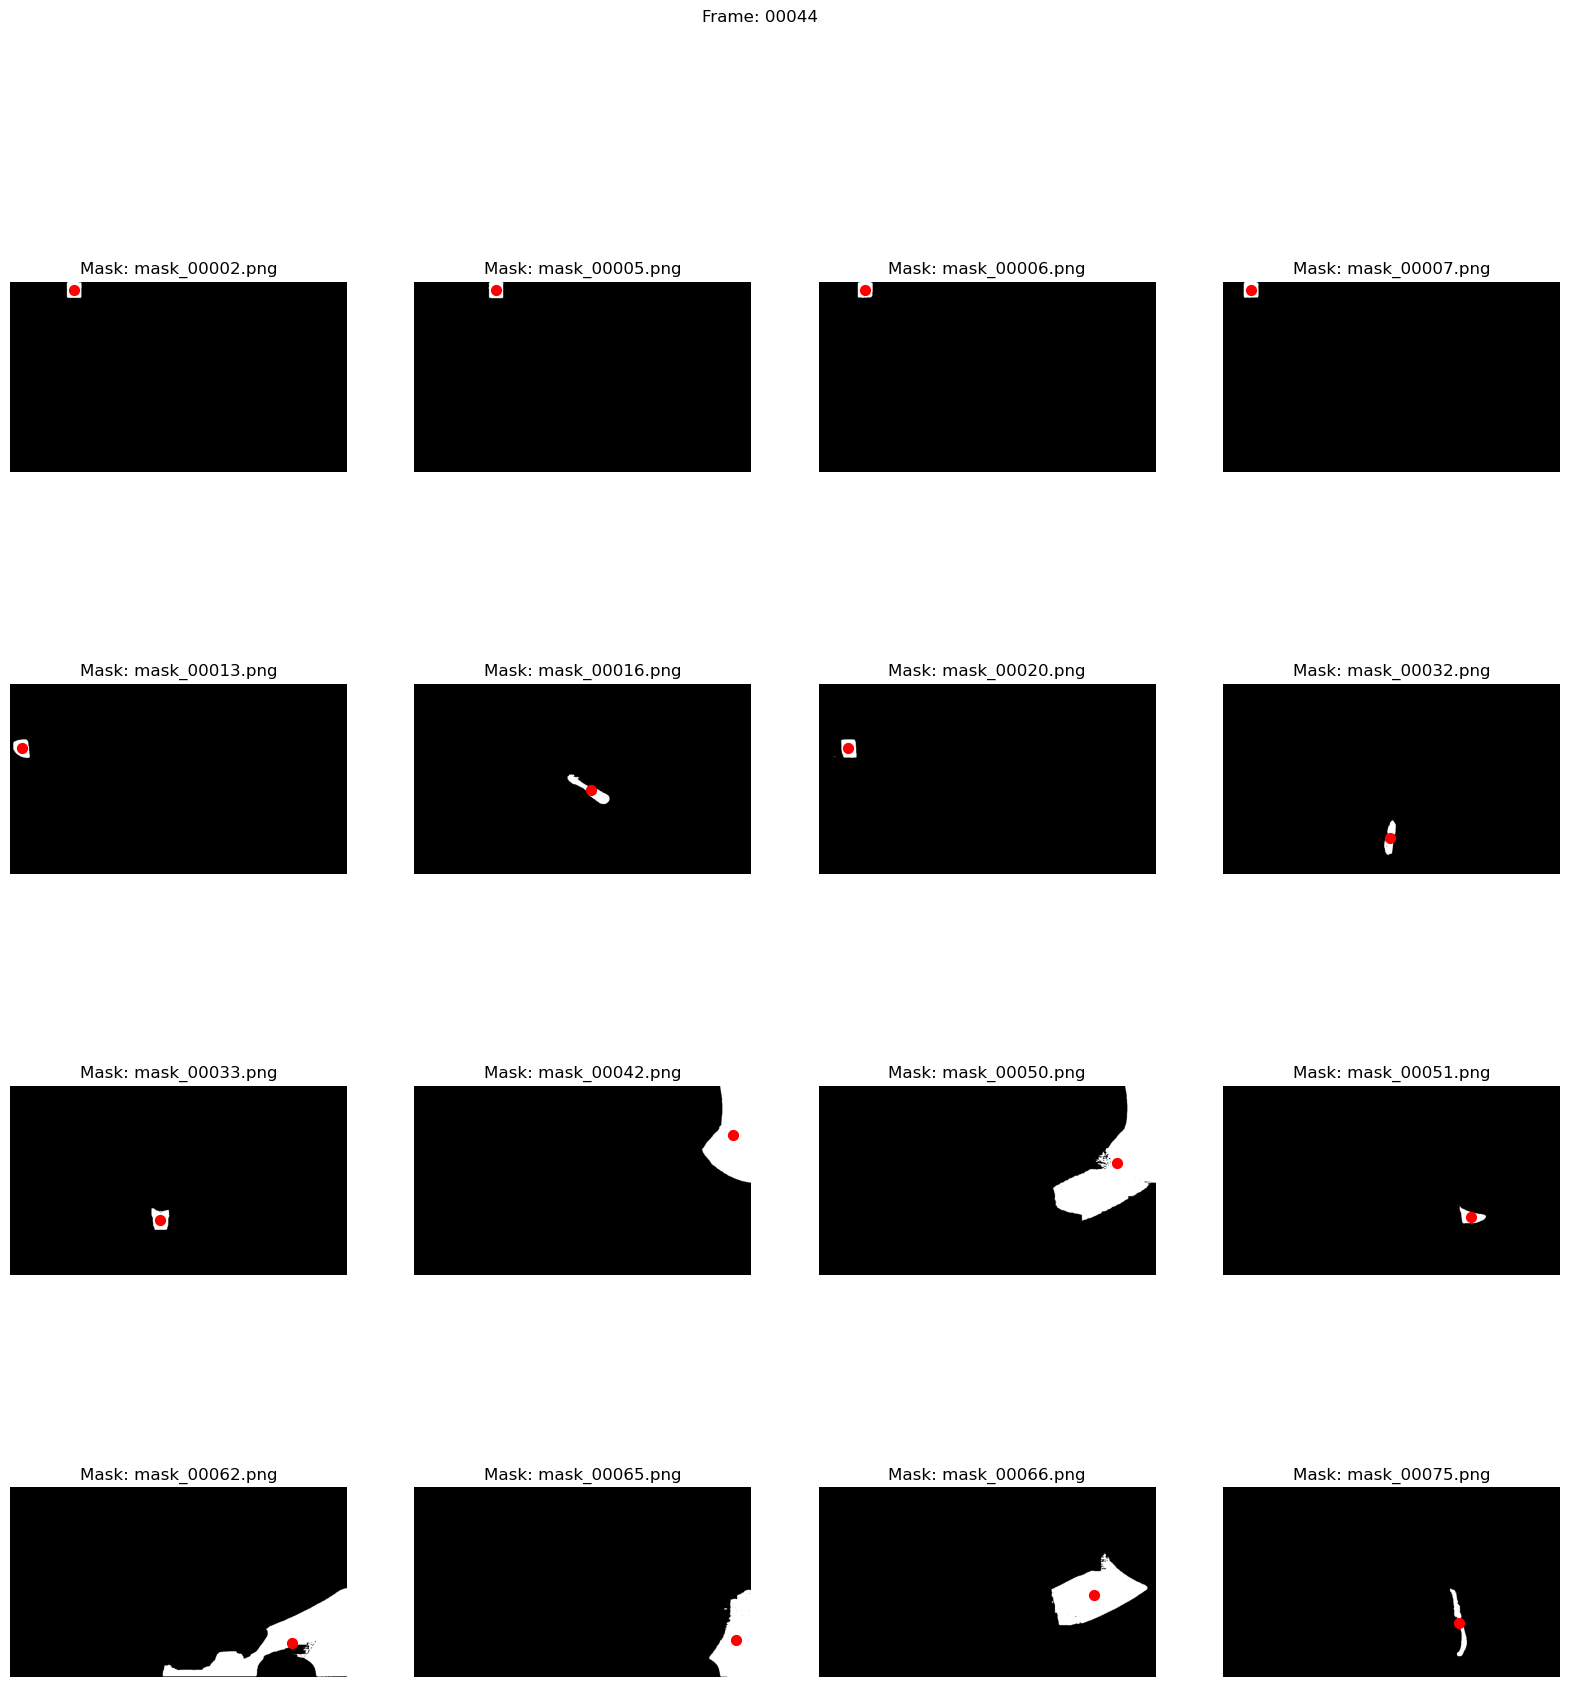

In [26]:
import os
import matplotlib.pyplot as plt

def plot_filtered_masks(filtered_masks, frame, folder='reel_fods_segmentation'):
    if frame not in filtered_masks:
        print(f"No masks found for frame {frame}")
        return
    
    masks = filtered_masks[frame]
    num_masks = len(masks)
    
    fig, axes = plt.subplots((num_masks + 3) // 4, 4, figsize=(20, 5 * ((num_masks + 3) // 4)))
    axes = axes.flatten()
    
    for ax, mask_file in zip(axes, masks.keys()):
        mask_path = os.path.join(folder, frame, mask_file)
        mask_image = plt.imread(mask_path)
        
        # Read barycentre from the JSON file
        barycentre = masks[mask_file]
        
        ax.imshow(mask_image, cmap='gray')
        ax.scatter(barycentre[0], barycentre[1], color='red', s=50)  # Plot barycentre as a red point
        ax.set_title(f'Mask: {mask_file}')
        ax.axis('off')
    
    # Hide any remaining empty subplots
    for ax in axes[num_masks:]:
        ax.axis('off')
    
    plt.suptitle(f'Frame: {frame}')
    plt.show()

# Example usage
frame_to_plot = '00044'
plot_filtered_masks(filtered_masks_reel, frame_to_plot)

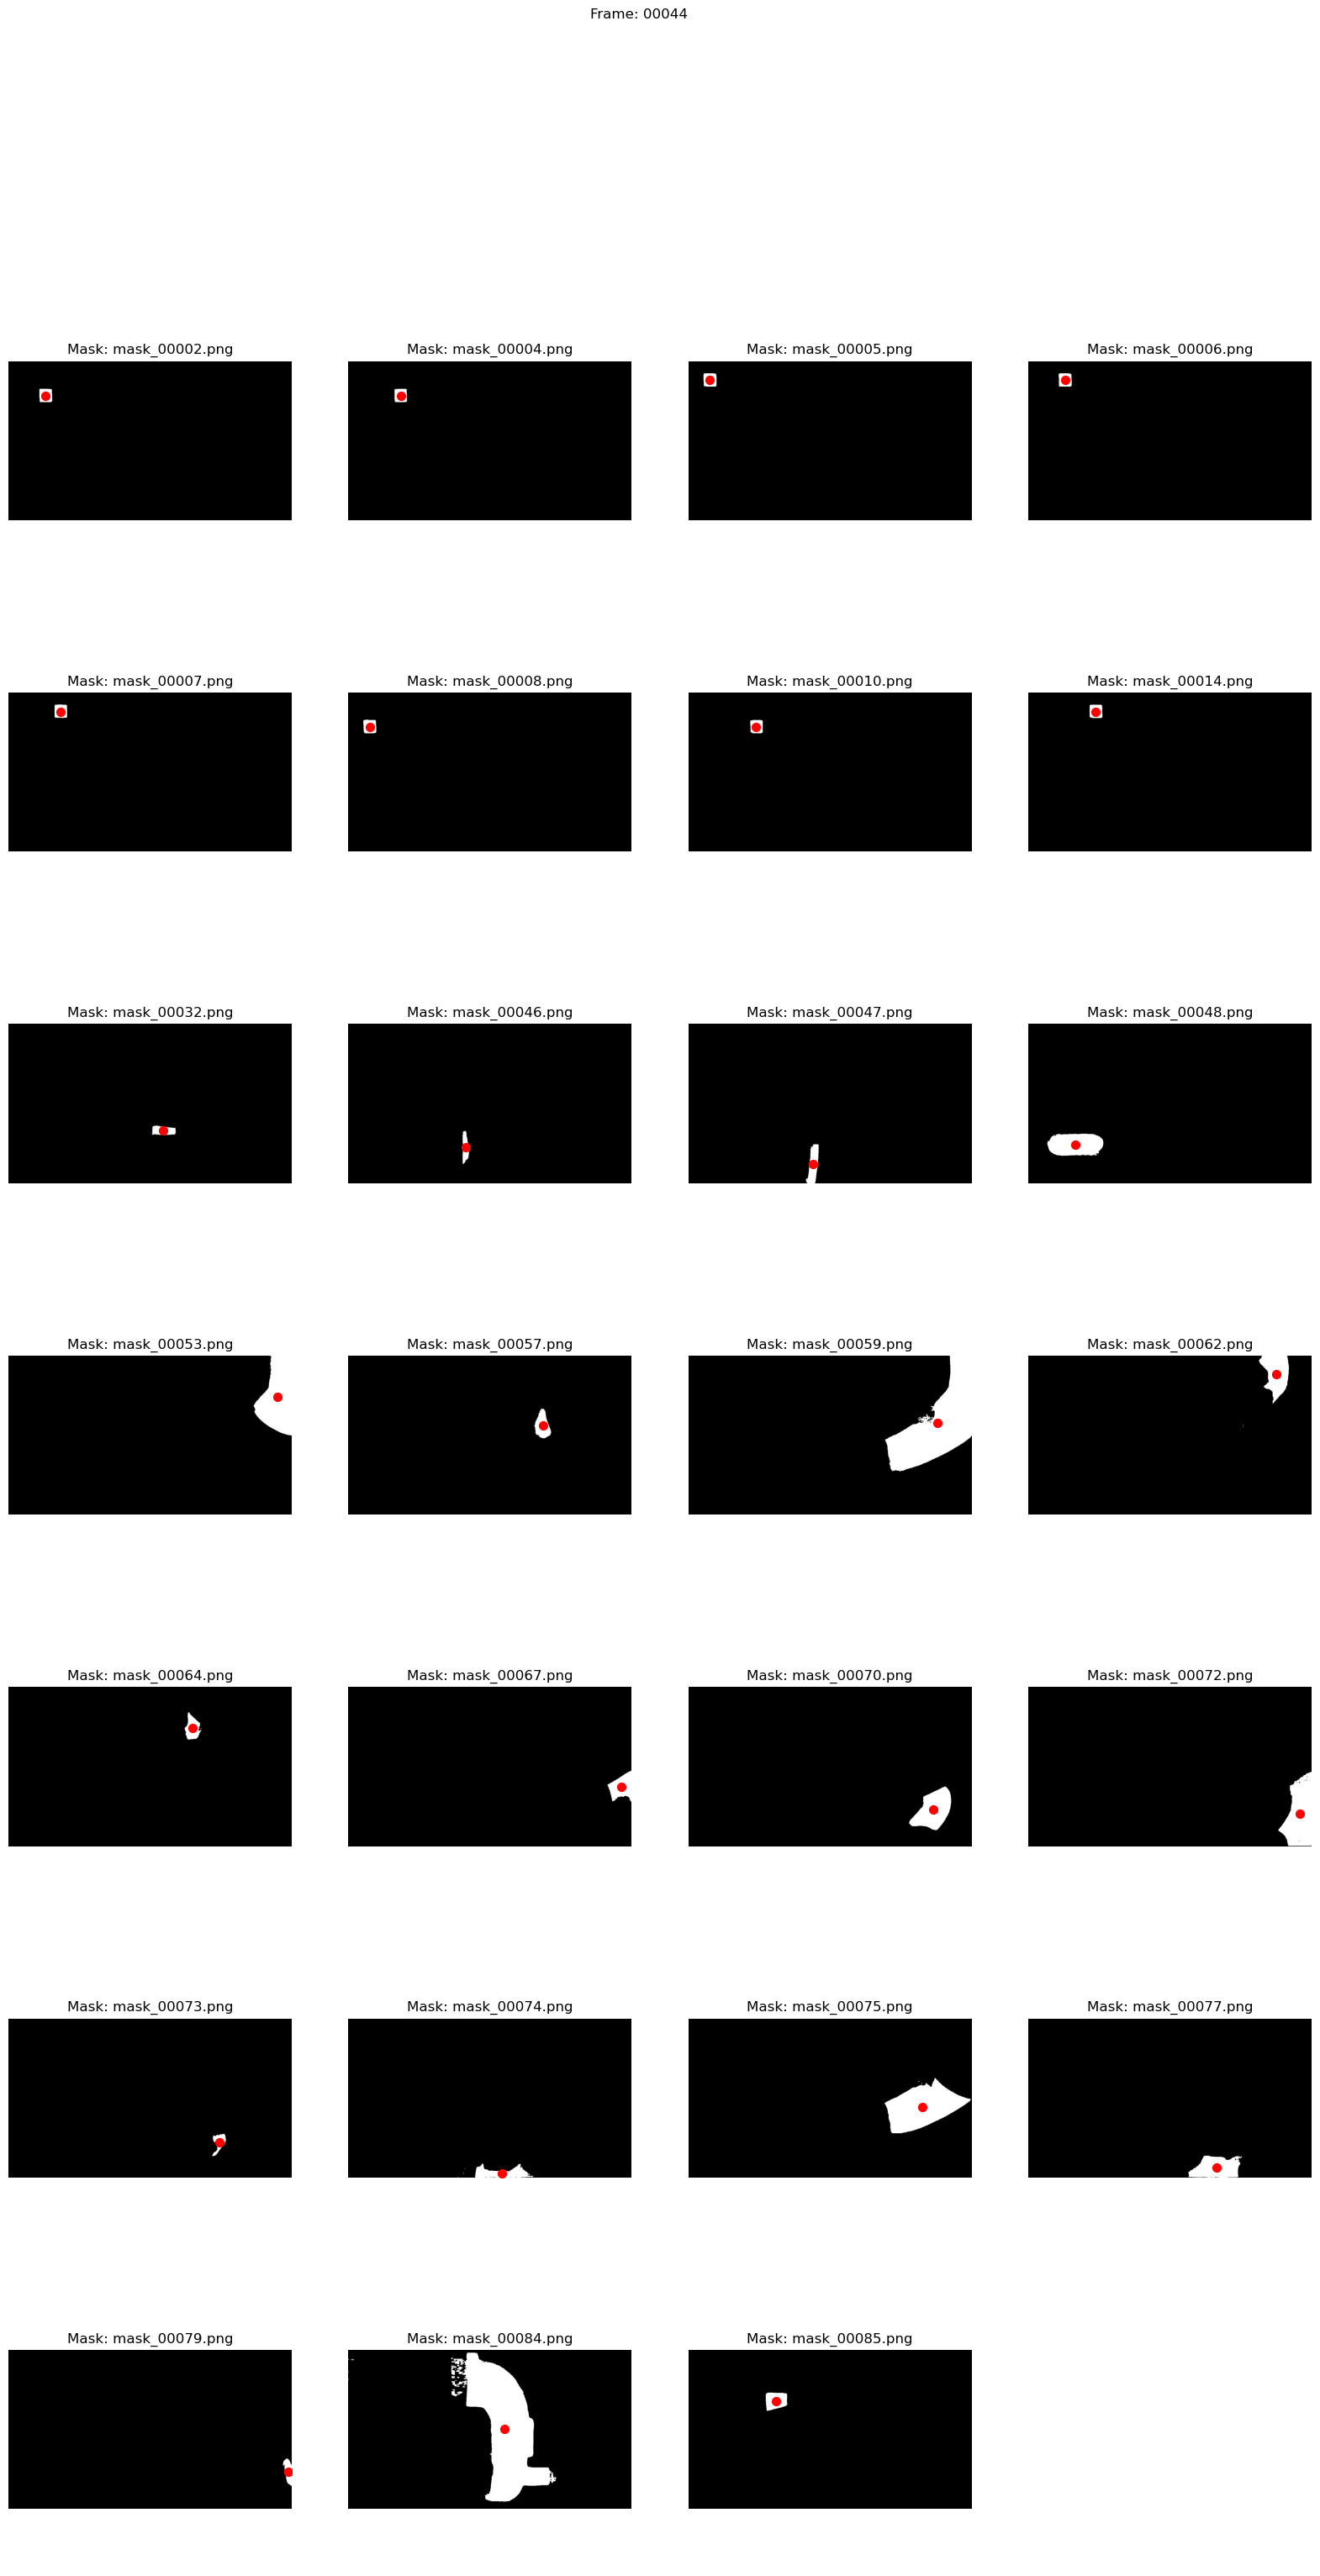

In [27]:
# Example usage
frame_to_plot = '00044'
plot_filtered_masks(filtered_masks_synthese, frame_to_plot,folder='synthetisated_fods_segmented')

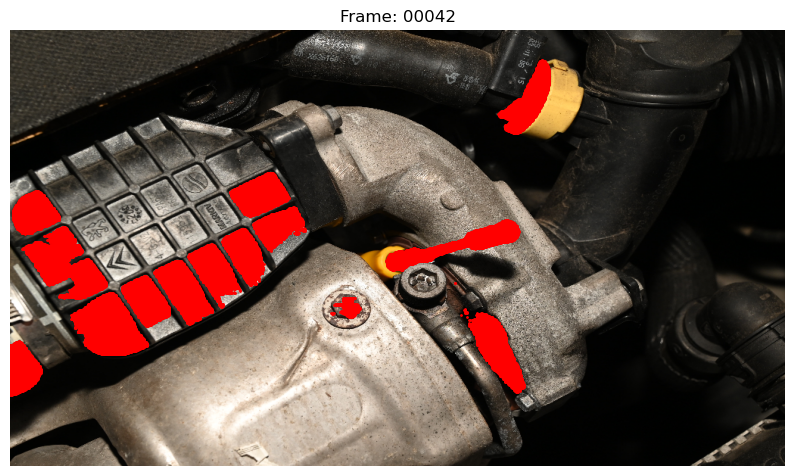

In [33]:
import os

import matplotlib.pyplot as plt

def plot_filtered_masks_on_original_image(filtered_masks, frame,segmented_folder ='reel_fods_segmentation', folder='images'):
    if frame not in filtered_masks:
        print(f"No masks found for frame {frame}")
        return
    
    masks = filtered_masks[frame]
    num_masks = len(masks)
    
    # Load the original image
    original_image_path = os.path.join(folder, f'frame_{int(frame)+1:05d}.JPG')
    original_image = plt.imread(original_image_path)
    
    # Resize the original image to 1024 width with a 16:9 ratio
    new_width = 1024
    new_height = int(new_width * 9 / 16)
    original_image = cv2.resize(original_image, (new_width, new_height))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(original_image)
    
    for mask_file in masks.keys():
        mask_path = os.path.join(segmented_folder, frame, mask_file)
        mask_image = plt.imread(mask_path)
        
        # Get the coordinates of the pixels where the mask is white (255)
        white_coords = np.column_stack(np.where(mask_image == 1))
        
        # Plot these coordinates as points on the original image
        ax.scatter(white_coords[:, 1], white_coords[:, 0], color='red', s=1)
    
    ax.set_title(f'Frame: {frame}')
    ax.axis('off')
    plt.show()

# Example usage
frame = '00042'

plot_filtered_masks_on_original_image(filtered_masks_reel, frame)

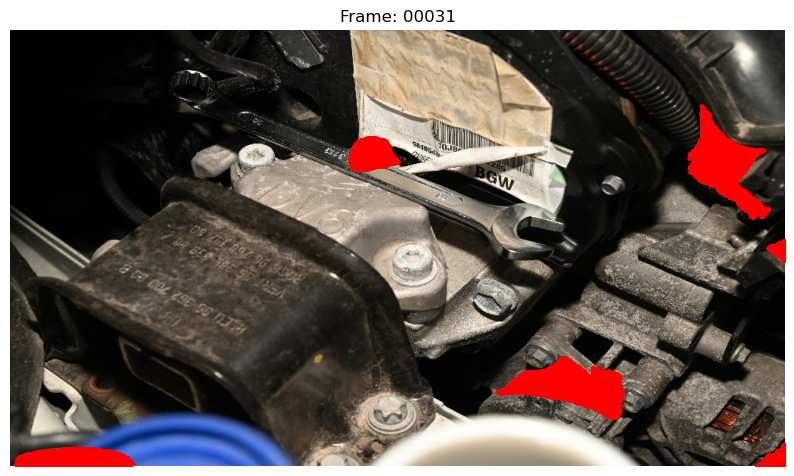

In [ ]:


plot_filtered_masks_on_original_image(filtered_masks_synthese, frame, segmented_folder='synthetisated_fods_segmented')

In [ ]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

def save_filtered_masks_on_original_image(filtered_masks, segmented_folder='reel_fods_segmentation', folder='images', output_folder='fod_detected'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for frame, masks in filtered_masks.items():
        if not masks:
            continue
        
        # Load the original image
        original_image_path = os.path.join(folder, f'frame_{int(frame)+1:05d}.JPG')
        original_image = plt.imread(original_image_path)
        
        # Resize the original image to 1024 width with a 16:9 ratio
        new_width = 1024
        new_height = int(new_width * 9 / 16)
        original_image = cv2.resize(original_image, (new_width, new_height))
        
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(original_image)
        
        for mask_file in masks.keys():
            mask_path = os.path.join(segmented_folder, frame, mask_file)
            mask_image = plt.imread(mask_path)
            
            # Get the coordinates of the pixels where the mask is white (255)
            white_coords = np.column_stack(np.where(mask_image == 1))
            
            # Plot these coordinates as points on the original image
            ax.scatter(white_coords[:, 1], white_coords[:, 0], color='red', s=1)
        
        ax.set_title(f'Frame: {frame}')
        ax.axis('off')
        
        # Save the figure
        output_path = os.path.join(output_folder, f'frame_{frame}.png')
        plt.savefig(output_path, bbox_inches='tight')
        plt.close(fig)

# Example usage
save_filtered_masks_on_original_image(filtered_masks_reel, output_folder='fod_detected')